# Analysis of Latent Space Reaction Attribute Vector for Acid Reduced to Alcohol

_Prepared by: Chih-Wei Hsu, Liang Xu, Christine Chang_

### Acid $(R-COOH)$ $\rightarrow$ Alcohol $(R-OH)$

This notebook uses the average reaction vector method to perform three tasks for alcohol dehydration as follow:
* Calculate the average and std dev of angle and magnitude of each vectors of reaction path,
* Calculate the difference between the predicted vectors and the actual vectors,
* Perform a deeper analysis of the molecules generated within 1 std dev of the average vector.

### Goal

Our goal is to evaluate the encoding of chemical reactions in DarkChem's latent space.  To do this, we are exploring the possibility of attribute vector arithmetic, e.g.

$\Big( \overrightarrow{product_{1}} - \overrightarrow{reactant_{1}} \Big) = \overrightarrow{reaction} \stackrel{?}{=} \Big( \overrightarrow{product_{2}} - \overrightarrow{reactant_{2}} \Big)$

### Approach

Our approach differs from prior analysis in the following ways:

   1. A **larger testing set** was used, consisting of 46 molecules (versus 10-25 used in prior analyses), which should yield a more robust reaction vector.
   2. A **similar class of reactants** was evaluated for the same reaction type.  For instance, only the reduction of all 3 double bonds in a benzene ring were conducted for various substituted benzene reactants; reduction of double bonds on linear alkenes or more complex/simple molecules were not tested.
   
### Key Findings

* The average reactant vector was determined, and the standard deviation was determined and applied to the average vector in order to better understand the latent space. 
    * Predicted products at exactly 1 standard deviation away from the average vector were determined.  For some reactants, this actually returned the expected product of the reaction.  However, for other reactants, this was not the case.
    * An interesting finding is that depending on the type of reactant, the accuracy of the ($\bar{x} \pm \sigma$) had directionality.  For instance, some reactants had a very accurate ($\bar{x} + \sigma$) vector and inaccurate ($\bar{x} - \sigma$) vector, whereas others had the reverse phenomenon.
* The average reactant vector accurately determined all products correctly for a testing set of 10 molecules, within a ~$k = 1-10$ beamsearch.

### Preparation

In [1]:
# Import the pakage we use
import math
import sys
sys.path.append('../')
from fcts import remove_space, r2pcorr, struc2mol
from usefct import difference, vector_magnitude, vector_angle, distribution
import numpy as np
import pandas as pd
import darkchem
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.linear_model import LinearRegression
from rdkit import Chem
from rdkit.Chem.Draw import MolToImage
from rdkit.Chem import PandasTools,Draw
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
import statistics
from IPython.display import display_html 

Using TensorFlow backend.


In [2]:
# Load model which generate the latent space 
model = darkchem.utils.load_model('../../../DarKnight_File/Final Trained DarkChem Network Weights/N7b_[M+H]/')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:
# load training set provided by PNNL
x = np.load('../../../DarKnight_File/Training Data - Molecules/combined_[M+H]_smiles.npy')

In [27]:
# load several Alcohol_Dehydration reactions from designated path
data = pd.read_excel('../../database/classified_reaction_types/acid_alcohol/acid_alcohol_train.xlsx')

# Remove the redundant space in the smiles string
data = remove_space(data)

# Transform reactants and products into dictionary
aatrain = {'reactants': data['Reactants'], 'products': data['Products']}

In [28]:
# Show the reactants we loaded
#Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in aatrain['reactants']], molsPerRow=10, subImgSize=(200, 200))

In [29]:
# Show the products we loaded
#Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in aatrain['products']], molsPerRow=10, subImgSize=(200, 200))

In [30]:
# Calculate the vectors of reactants and products
rvec = [darkchem.utils.struct2vec(reactant) for reactant in aatrain['reactants']]
pvec = [darkchem.utils.struct2vec(product) for product in aatrain['products']]
# Transform the data type to np.array 
# For the calculation of latent space vectors
rvec = np.array(rvec).astype(int)
pvec = np.array(pvec).astype(int)

In [31]:
# Generate the latent space representation for reactants and products
r_latent = model.encoder.predict(rvec)
p_latent = model.encoder.predict(pvec)

In [32]:
# Transform the data type to DataFrame 
rvecdf = pd.DataFrame(r_latent)
pvecdf = pd.DataFrame(p_latent)

### Method

In [33]:
# Calculate the latent path vector for those 28 reactions
path = pvecdf - rvecdf

In [34]:
# Calculate the average of path vector
path_vec =np.array(path.mean().values)

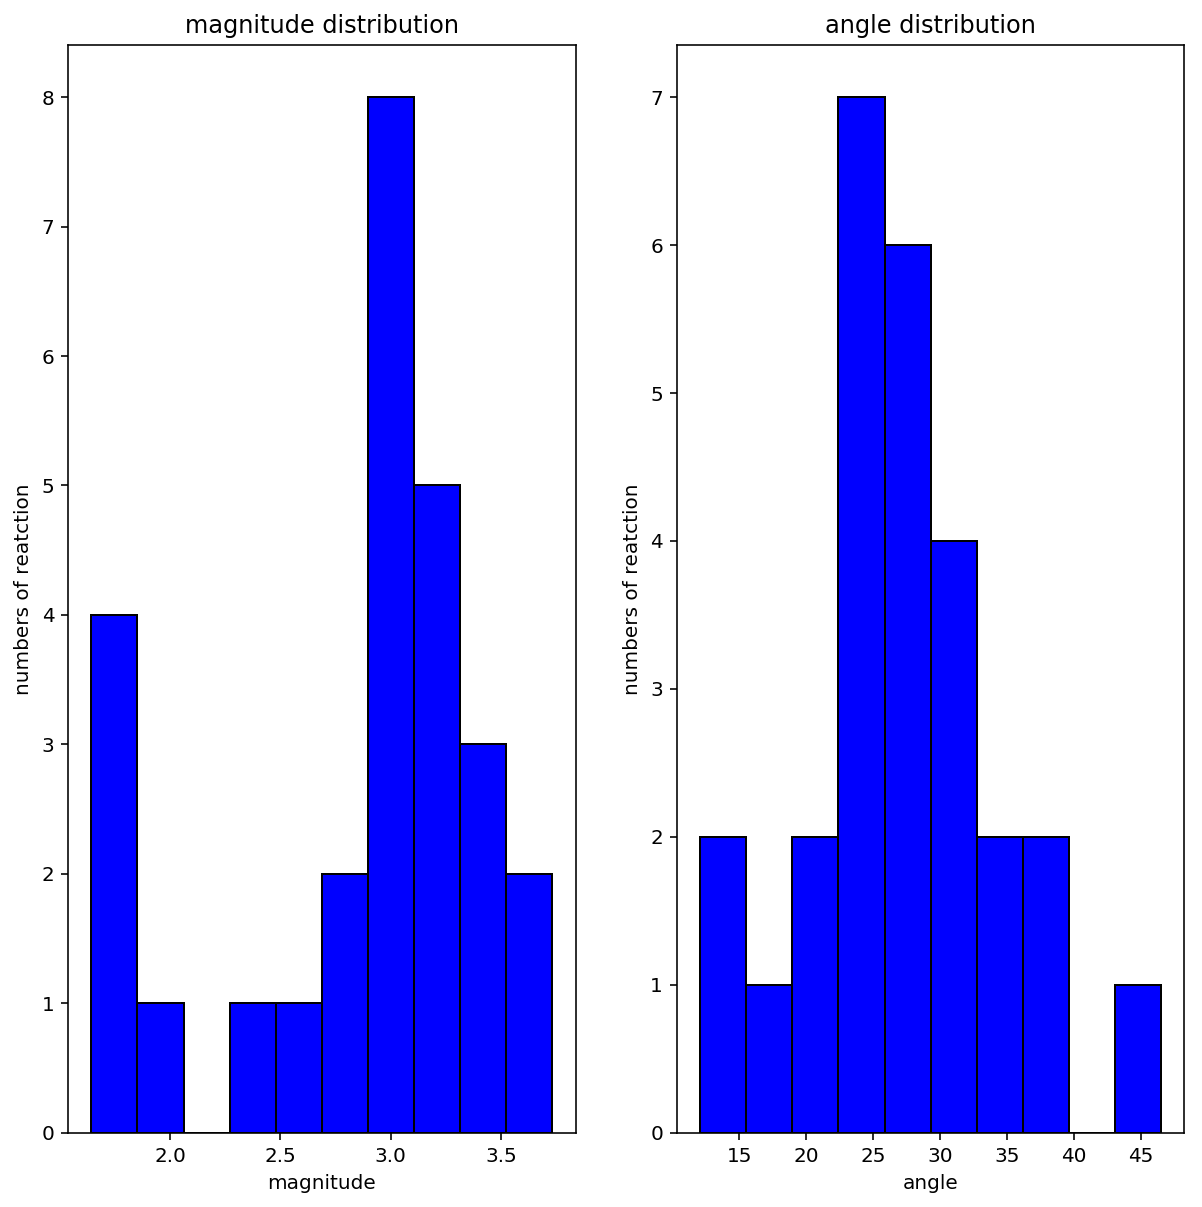

In [35]:
# Show the distribution of magnitude and angle of each path vector
distribution(path,rvecdf,pvecdf)

In [36]:
# Calculate the average and std deviation of magnitude of path vectors
vector_magnitude(path)

The average magnitude is: 2.8460683554361954
The std magnitude is: 0.6020907163057767


In [37]:
# Calculate the average and std deviation of the angle between products and reactants vectors
vector_angle(rvecdf,pvecdf)

The average angle is: 26.975738033765218
The std angle is: 7.225208789459021


### Prediction

In [49]:
# Load several Acid_Alcohol reactions from designated path as testing set
data = pd.read_excel('../../database/classified_reaction_types/acid_alcohol/acid_alcohol_test.xlsx')

# Remove the redundant space in the smiles string
data = remove_space(data)

# Transform reactants and products into dictionary
aatest = {'reactants': data['Reactants'], 'products': data['Products']}

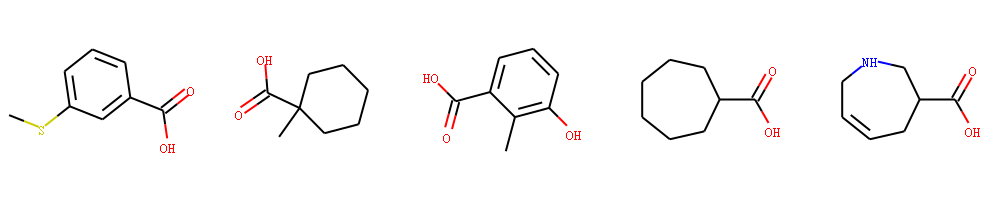

In [50]:
# Show the testing reactants we loaded
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in aatest['reactants']], molsPerRow=5, subImgSize=(200, 200))

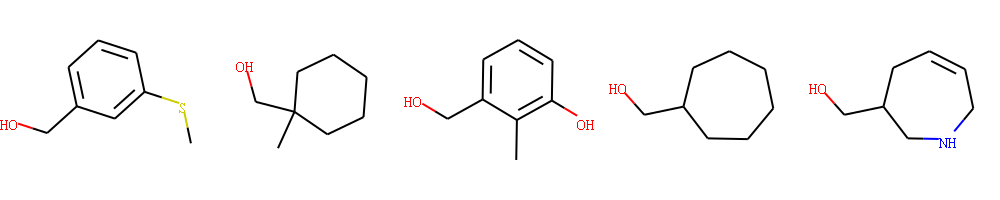

In [51]:
# Show the testing products we loaded
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in aatest['products']], molsPerRow=5, subImgSize=(200, 200))

The result showed in the dataframe below:

index|             Reactant|             Product|The closest predicted product|Accuracy|
-----|---------------------|--------------------|-----------------------------|--------|
    1|   CSc1cccc(c1)C(=O)O|      OCc1cccc(c1)SC|-----------------------------|  Failed|
    2|    OC(=O)C1(C)CCCCC1|       OCC1(C)CCCCC1|-----------------------------|  Failed|
    3|   OC(=O)c1cccc(c1C)O|      OCc1cccc(c1C)O|-----------------------------|  Failed|
    4|      OC(=O)C1CCCCCC1|         OCC1CCCCCC1|-----------------------------|  Failed|
    5|     OC(=O)C1CNCC=CC1|        OCC1CNCC=CC1|-----------------------------|  Failed|


Below are the prediction of each testing reactions:

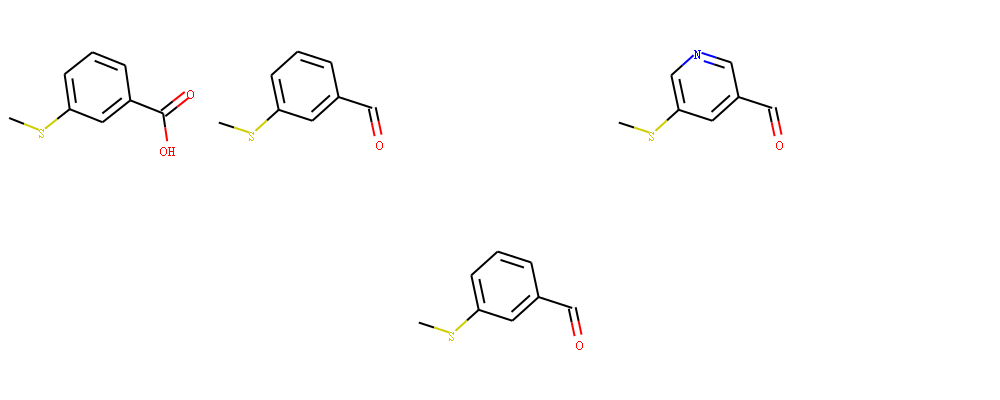

In [52]:
# Predict the 1st reaction in the training set 
r_p1 = aatest['reactants'][0]
rvec_p1 = [darkchem.utils.struct2vec(r_p1)]
rvec_p1 = np.array(rvec_p1).astype(int)
r_p1_latent = model.encoder.predict(rvec_p1)
p_p1_latent = r_p1_latent + path_vec
pvec_p1 = model.decoder.predict(p_p1_latent)
p_p1 = darkchem.utils.beamsearch(pvec_p1, k=10)
df = {}
df['p_p1'] = [darkchem.utils.vec2struct(i) for i in p_p1[0]]
df['p_p1_mol'] = [Chem.MolFromSmiles(df['p_p1'][i]) for i in range(len(df['p_p1']))]
img = Chem.Draw.MolsToGridImage(df['p_p1_mol'], molsPerRow=5, subImgSize=(200, 200))
img

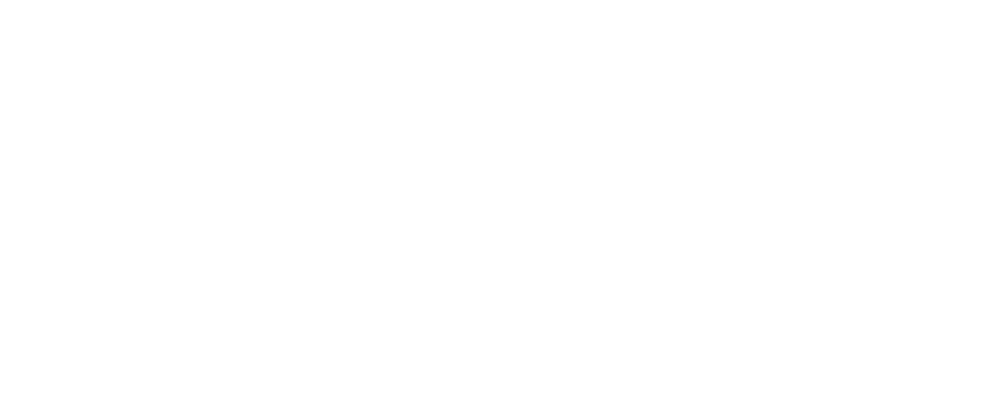

In [62]:
# Predict the 2rd reaction in the training set 
r_p2 = aatest['reactants'][1]
rvec_p2 = [darkchem.utils.struct2vec(r_p2)]
rvec_p2 = np.array(rvec_p2).astype(int)
r_p2_latent = model.encoder.predict(rvec_p2)
p_p2_latent = r_p2_latent + path_vec
pvec_p2 = model.decoder.predict(p_p2_latent)
p_p2 = darkchem.utils.beamsearch(pvec_p2, k=10)
df = {}
df['p_p2'] = [darkchem.utils.vec2struct(i) for i in p_p2[0]]
df['p_p2_mol'] = [Chem.MolFromSmiles(df['p_p2'][i]) for i in range(len(df['p_p2']))]
img = Chem.Draw.MolsToGridImage(df['p_p2_mol'], molsPerRow=5, subImgSize=(200, 200))
img

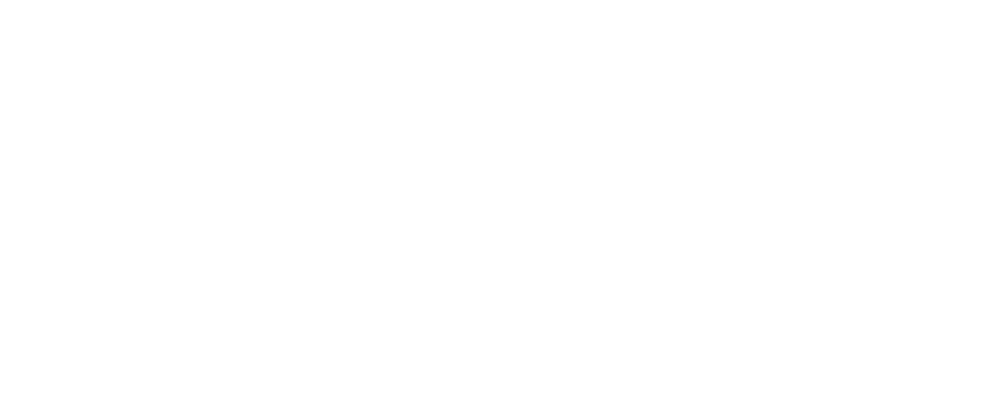

In [46]:
# Predict the 3rd reaction in the training set 
r_p3 = aatest['reactants'][2]
rvec_p3 = [darkchem.utils.struct2vec(r_p3)]
rvec_p3 = np.array(rvec_p3).astype(int)
r_p3_latent = model.encoder.predict(rvec_p3)
p_p3_latent = r_p3_latent + path_vec
pvec_p3 = model.decoder.predict(p_p3_latent)
p_p3 = darkchem.utils.beamsearch(pvec_p3, k=10)
df = {}
df['p_p3'] = [darkchem.utils.vec2struct(i) for i in p_p3[0]]
df['p_p3_mol'] = [Chem.MolFromSmiles(df['p_p3'][i]) for i in range(len(df['p_p3']))]
img = Chem.Draw.MolsToGridImage(df['p_p3_mol'], molsPerRow=5, subImgSize=(200, 200))
img

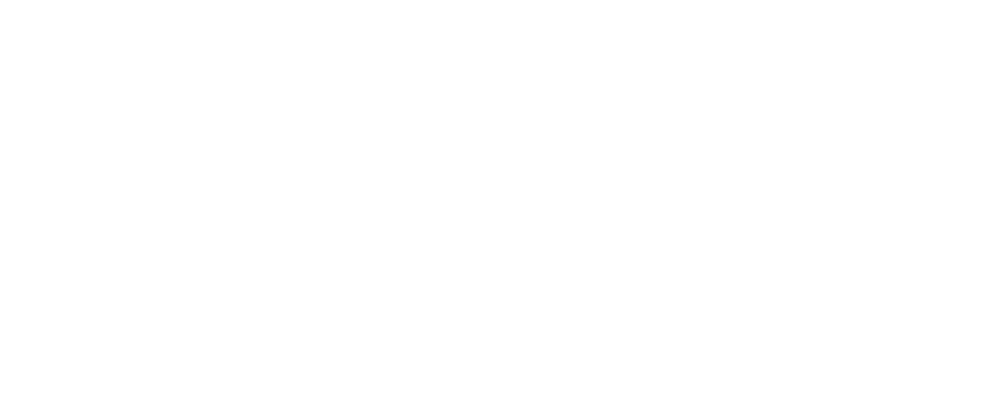

In [47]:
# Predict the 4th reaction in the training set 
r_p4 = aatest['reactants'][3]
rvec_p4 = [darkchem.utils.struct2vec(r_p4)]
rvec_p4 = np.array(rvec_p4).astype(int)
r_p4_latent = model.encoder.predict(rvec_p4)
p_p4_latent = r_p4_latent + path_vec
pvec_p4 = model.decoder.predict(p_p4_latent)
p_p4 = darkchem.utils.beamsearch(pvec_p4, k=10)
df = {}
df['p_p4'] = [darkchem.utils.vec2struct(i) for i in p_p4[0]]
df['p_p4_mol'] = [Chem.MolFromSmiles(df['p_p4'][i]) for i in range(len(df['p_p4']))]
img = Chem.Draw.MolsToGridImage(df['p_p4_mol'], molsPerRow=5, subImgSize=(200, 200))
img

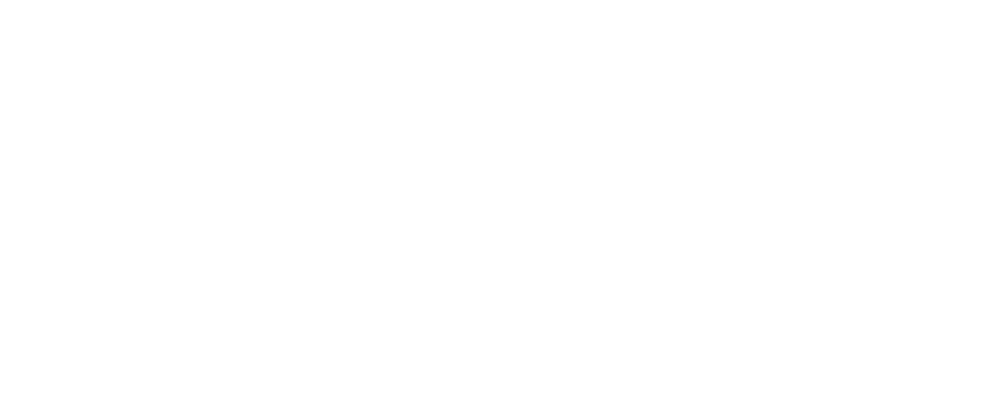

In [48]:
# Predict the 5th reaction in the training set 
r_p5 = aatest['reactants'][4]
rvec_p5 = [darkchem.utils.struct2vec(r_p5)]
rvec_p5 = np.array(rvec_p5).astype(int)
r_p5_latent = model.encoder.predict(rvec_p5)
p_p5_latent = r_p5_latent + path_vec
pvec_p5 = model.decoder.predict(p_p5_latent)
p_p5 = darkchem.utils.beamsearch(pvec_p5, k=10)
df = {}
df['p_p5'] = [darkchem.utils.vec2struct(i) for i in p_p5[0]]
df['p_p5_mol'] = [Chem.MolFromSmiles(df['p_p5'][i]) for i in range(len(df['p_p5']))]
img = Chem.Draw.MolsToGridImage(df['p_p5_mol'], molsPerRow=5, subImgSize=(200, 200))
img

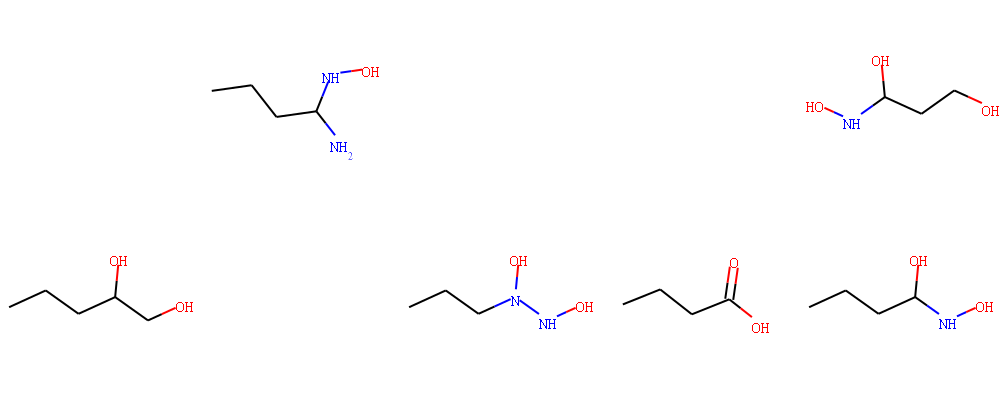

In [63]:
# Predict a random reaction in the training set 
r_p6 = 'CCCC(=O)O'
rvec_p6 = [darkchem.utils.struct2vec(r_p6)]
rvec_p6 = np.array(rvec_p6).astype(int)
r_p6_latent = model.encoder.predict(rvec_p6)
p_p6_latent = r_p6_latent + path_vec
pvec_p6 = model.decoder.predict(p_p6_latent)
p_p6 = darkchem.utils.beamsearch(pvec_p6, k=10)
df = {}
df['p_p6'] = [darkchem.utils.vec2struct(i) for i in p_p6[0]]
df['p_p6_mol'] = [Chem.MolFromSmiles(df['p_p6'][i]) for i in range(len(df['p_p6']))]
img = Chem.Draw.MolsToGridImage(df['p_p6_mol'], molsPerRow=5, subImgSize=(200, 200))
img

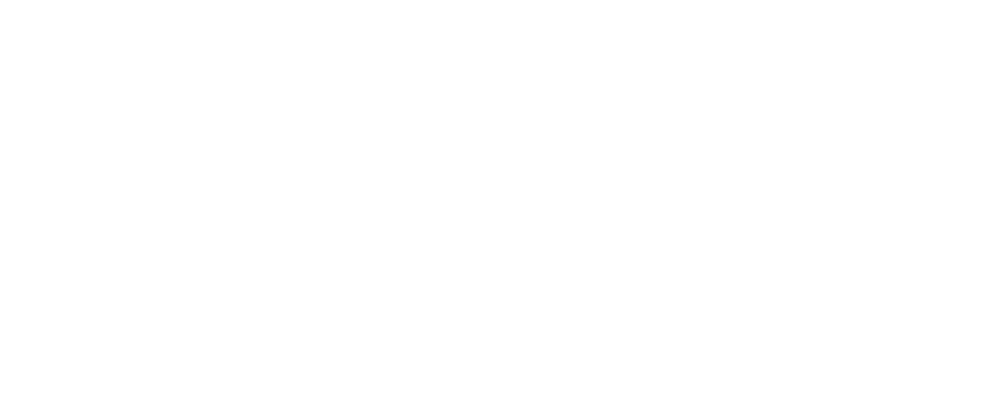

In [64]:
# Predict a random reaction in the training set 
r_p7 = 'OC(=O)C1CCCC=C1'
rvec_p7 = [darkchem.utils.struct2vec(r_p7)]
rvec_p7 = np.array(rvec_p7).astype(int)
r_p7_latent = model.encoder.predict(rvec_p7)
p_p7_latent = r_p7_latent + path_vec
pvec_p7 = model.decoder.predict(p_p7_latent)
p_p7 = darkchem.utils.beamsearch(pvec_p7, k=10)
df = {}
df['p_p7'] = [darkchem.utils.vec2struct(i) for i in p_p7[0]]
df['p_p7_mol'] = [Chem.MolFromSmiles(df['p_p7'][i]) for i in range(len(df['p_p7']))]
img = Chem.Draw.MolsToGridImage(df['p_p7_mol'], molsPerRow=5, subImgSize=(200, 200))
img